In [3]:
import time
import os
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle
from numpy import array


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

from sklearn.metrics import log_loss
from joblib import parallel_backend
from joblib import Parallel, delayed


import dask
from dask.distributed import Client, progress, LocalCluster, SSHCluster,wait
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from PyALE import ale

In [4]:
#import data

comb_dinuc_df= pd.read_csv('/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/FR_DCL/train/data_sets/FR_dcl_tr_set1_df.txt',header=0,sep='\t')
#np.shape(comb_dinuc_df)
shuf_comb_dinuc_df=comb_dinuc_df.iloc[np.random.permutation(len(comb_dinuc_df))]
shuf_comb_dinuc_df=shuf_comb_dinuc_df.reset_index(drop=True)

In [5]:
#drop seq_id
shuf_comb_dinuc_dfdrp= shuf_comb_dinuc_df.drop(['seq_id'],axis=1)
shuf_comb_dinuc_dfdrp.head()

,5p,3p,strand,ptype,length,gc_cont,AA,AC,AG,AT,...,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,4658,4841,1,1,202,0.272277,43,2,8,21,...,0,8,10,6,4,17,15,7,24,26
1,710,1526,1,1,817,0.569155,44,49,59,38,...,51,61,52,72,35,32,17,69,45,30
2,4423,4841,1,0,428,0.432243,64,7,30,32,...,22,21,39,27,22,24,15,24,38,32
3,4408,4838,1,0,455,0.419780,77,9,35,31,...,22,21,45,26,24,27,17,21,41,32
4,4680,4841,1,1,177,0.237288,36,2,4,21,...,0,8,9,3,4,14,14,7,21,29


In [7]:
ydt=shuf_comb_dinuc_df['ptype']
xdt=shuf_comb_dinuc_df.drop(['seq_id','ptype'],axis=1)


In [8]:
######################### split data #####################################

#split test train data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(xdt, ydt, test_size=0.2, random_state=256)
Xdt_train.shape, Xdt_test.shape

((2154341, 21), (538586, 21))

In [9]:
with parallel_backend('threading',n_jobs=52 ):

    #print('traing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    # Calculate class weights
    #class_weights = compute_class_weight('balanced', classes=np.unique(ydt_train), y=ydt_train)
    #class_weights

    rfc_dicomb = RandomForestClassifier(random_state=3500,n_estimators = 250,n_jobs=52)
    
    #class_weight=dict(enumerate(class_weights) ))




#    rfc_dicomb = RandomForestClassifier(random_state=3500,n_estimators = 400,n_jobs=32,
#     class_weight=dict(enumerate(class_weights) ),
#     criterion='log_loss',
#        max_depth=100,
#        min_samples_split=10,
#        min_samples_leaf=2,
#        max_features='log2',
#        bootstrap=True
#        )

    
    print('training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    #model train
    rfc_dicomb.fit(Xdt_train, ydt_train)


    # Predict the Test set results

    y_pred =  rfc_dicomb.predict(Xdt_test)


training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [10]:
###############################################################################

# test accuracy score 

from sklearn.metrics import accuracy_score

print('Model test accuracy : {0:0.4f}'. format(accuracy_score(ydt_test, y_pred)))

print ("\nClassification report :\n",(classification_report(ydt_test,y_pred)))

Model test accuracy : 0.8037

Classification report :
               precision    recall  f1-score   support

           0       0.87      0.77      0.82    313636
           1       0.73      0.84      0.78    224950

    accuracy                           0.80    538586
   macro avg       0.80      0.81      0.80    538586
weighted avg       0.81      0.80      0.80    538586



In [11]:
mfilename='/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/RP_dcl/models/rfc_rp_dcl_comb_set1_v1.pkl'

pickle.dump( rfc_dicomb,open(mfilename,'wb'))

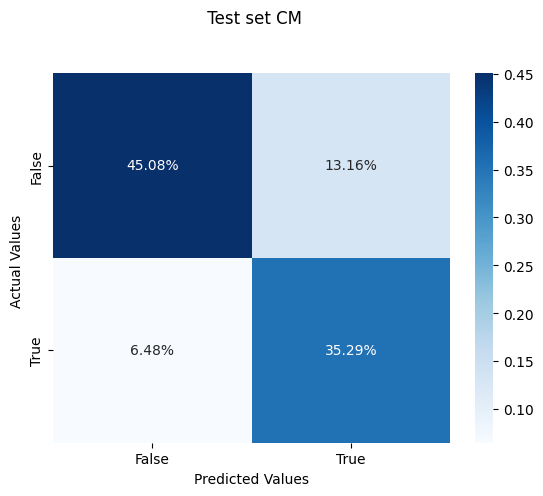

In [12]:
plt.rcParams.update({'font.size': 10})
fig1=plt.figure()
cm = confusion_matrix(y_true=ydt_test, y_pred=y_pred)

ax = sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title(' Test set CM\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


fig1 = ax.get_figure()
fig1.savefig('RFC_dcl_rp_set1.pdf', dpi=400)

In [13]:
client = Client(processes=False, threads_per_worker=1, n_workers=64, memory_limit='256GB')

In [14]:
start_time=time.time()


# Scatter X data to workers
Xdt_test_dask = client.scatter(Xdt_test, broadcast=True)
# Scatter y data to workers
ydt_test_dask = client.scatter(ydt_test, broadcast=True)  


@dask.delayed
def compute_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    return result

# Compute permutation importance with Dask delayed computation
perm_importance_delayed = compute_permutation_importance(rfc_dicomb, Xdt_test_dask, ydt_test_dask)

# Compute the result
perm_importance_t3 = perm_importance_delayed.compute()


end_time=time.time()
total_time=end_time-start_time
print("execution time",total_time,"s")

/mnt/pixstor/data/tsrbcx/miniconda/envs/sickt_ml/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 13.11 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


execution time 530.7926745414734 s


In [15]:
client.close()

In [16]:
sorted_idx = perm_importance_t3.importances_mean.argsort()
top_fidx=sorted_idx[-22:]

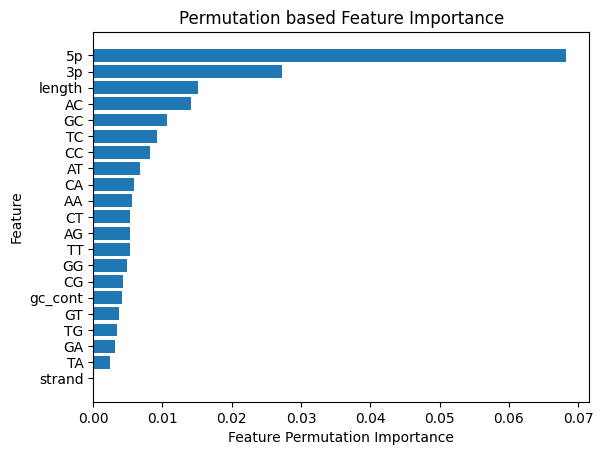

In [17]:
plt.rcParams.update({'font.size': 10})
fig4=plt.figure()
plt.barh(Xdt_train.columns[top_fidx], perm_importance_t3.importances_mean[top_fidx])
plt.xlabel("Feature Permutation Importance")
plt.ylabel('Feature')
plt.title('Permutation based Feature Importance')
fig4.savefig("Permutation_based_FI_dinuc_rp_dcl_tr_set1.pdf")

In [19]:
di_fe=['5p','3p','length']

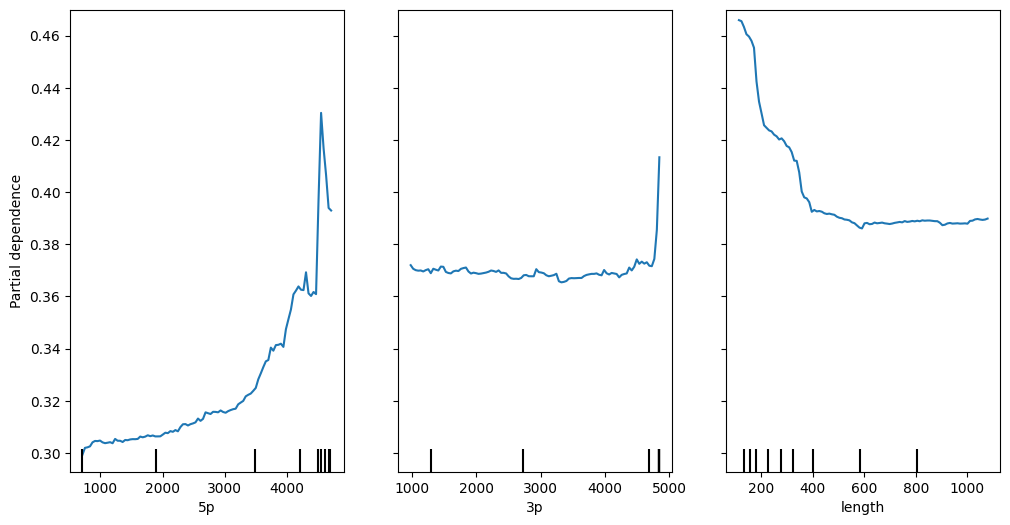

In [20]:
fig2, ax = plt.subplots(figsize=(12, 6))

tree_disp = PartialDependenceDisplay.from_estimator(rfc_dicomb,X=Xdt_test,features=di_fe, ax=ax,n_jobs=64)

In [21]:
fig2.savefig('rp_dcl_pdp.pdf',dpi=300)